In [ ]:
from google.colab import drive
drive.mount('content')

Mounted at content


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import polars as pl
import lightgbm as lgb
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error
import pickle, time, logging, glob, pathlib, random
from sklearn.metrics import r2_score
import torch, math
from torch.utils.data import  Dataset, DataLoader
from functools import lru_cache
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn

root = pathlib.Path(f"/content/content/MyDrive/Kaggle Competitions/Jane Street/train.npy")
def get_paths(nums: list) -> list:
    return [root/f"symbol={i}/window=4/part-0.npz" for i in nums]

train_paths = get_paths(range(36))
val_paths = get_paths(range(36,38))
final_path = get_paths([38])

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
cfg = {
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "window": 4,
    "batch_size":96,#96,
    "shuffle":False,
    "dim": np.load(train_paths[0], allow_pickle=True)["data"].shape[-1],
    "drop_last":True,
    "num_workers":1,
    "frac": None,
    "pin_memory": True,
    "prefetch_factor":2
}

In [ ]:
cfg

{'device': device(type='cpu'),
 'window': 4,
 'batch_size': 96,
 'shuffle': False,
 'dim': 32,
 'drop_last': True,
 'num_workers': 1,
 'frac': None,
 'pin_memory': True,
 'prefetch_factor': 2}

In [ ]:
class JaneStreetDatasetV1(Dataset):
    def __init__(self, paths, cfg):
        self.file_mappings = []
        self.total_rows = 0
        self.frac = cfg["frac"]


        for path in tqdm(paths, desc="Processing financial instruments"):
            data = np.load(path,allow_pickle=True)["target"]
            size = int(data.shape[0] * self.frac) if self.frac else data.shape[0]
            self.file_mappings.append((path, self.total_rows, self.total_rows + size)) # Map cumulative row count to file path
            self.total_rows += size


    @lru_cache(maxsize = 10)
    def load_file(self, path_name):
        train_npy = np.load(path_name, allow_pickle=True, mmap_mode="r")
        return train_npy["data"], train_npy["target"]

    def __len__(self):
        return self.total_rows

    def __getitem__(self, idx):
        for path, offset, sum_k in self.file_mappings:
            if idx < sum_k:
                size = idx - offset
                data, targets = self.load_file(path)
                return (
                    torch.tensor(data[size], dtype=torch.float32),
                    torch.tensor(targets[size], dtype=torch.float32).unsqueeze(0)
                )

In [ ]:
def create_dataloader_v1(paths, cfg):
    dataset = JaneStreetDatasetV1(paths, cfg)
    dataloader = DataLoader(dataset=dataset,
                            batch_size=cfg["batch_size"],
                            shuffle=cfg["shuffle"],
                            drop_last=cfg["drop_last"],
                            num_workers=cfg["num_workers"]
                           )

    return dataloader

In [ ]:
def get_slopes(n):
    def get_slopes_power_of_2(n):
        start = (2**(-2**-(math.log2(n)-3)))
        ratio = start
        return [start*ratio**i for i in range(n)]

    if math.log2(n).is_integer():
        return get_slopes_power_of_2(n)                   #In the paper, we only train models that have 2^a heads for some a. This function has
    else:                                                 #some good properties that only occur when the input is a power of 2. To maintain that even
        closest_power_of_2 = 2**math.floor(math.log2(n))  #when the number of heads is not a power of 2, we use this workaround.
        return get_slopes_power_of_2(closest_power_of_2) + get_slopes(2*closest_power_of_2)[0::2][:n-closest_power_of_2]

def get_alibi_slope(num_heads):
    return torch.Tensor(get_slopes(num_heads)).unsqueeze(1).unsqueeze(1)

def get_alibi_bias(num_heads, seq_len):
    relative_pos = torch.arange(seq_len)[None, :] - torch.arange(seq_len)[:, None]
    m = get_alibi_slope(num_heads)
    return m * relative_pos

def init_weights(m):
    if isinstance(m, torch.nn.Linear):
      torch.nn.init.normal_(m.weight, mean=0.0, std=1/math.sqrt(6)) #torch.nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
      if m.bias is not None:
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, torch.nn.Embedding):
        torch.nn.init.normal_(m.weight, mean=0.0, std=1/math.sqrt(6))

class MultiHeadMaskAttention(torch.nn.Module):
    def __init__(self, dim_in, dim_out, num_heads, window, bias):
        super().__init__()
        self.num_heads = num_heads
        self.pos_emb = torch.nn.Embedding(window, dim_in)
        self.W_query = torch.nn.Linear(dim_in, dim_out*num_heads, bias=bias)
        self.W_key = torch.nn.Linear(dim_in, dim_out*num_heads, bias=bias)
        self.W_value = torch.nn.Linear(dim_in, dim_out*num_heads, bias=bias)
        self.out_proj = torch.nn.Linear(dim_out, dim_out)
        self.softmax = torch.nn.Softmax(dim=-1)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(window,window), diagonal=1).bool()
        )
        self.register_buffer(
            "bias",
            get_alibi_bias(num_heads, window)
        )

    def forward(self, inp):
        batch, window, emb = inp.shape
        pos_emb = self.pos_emb(torch.arange(window, device=inp.device))

        queries = self.W_query(inp)
        keys = self.W_key(inp)
        values = self.W_value(inp)

        keys = keys.view(batch, window, self.num_heads, emb)
        queries = queries.view(batch, window, self.num_heads, emb)
        values = values.view(batch, window, self.num_heads, emb)

        keys = keys.transpose(1,2)
        queries = queries.transpose(1,2)
        values = values.transpose(1,2) + pos_emb

        attn_scores = (queries @ keys.mT)/math.sqrt(keys.shape[-1]) + self.bias
        attn_scores = attn_scores.masked_fill(self.mask, -torch.inf)
        attn_weights = self.softmax(attn_scores)
        context_vectors = (attn_weights @ values).transpose(1,2).mean(dim=-2)
        return self.out_proj(context_vectors)/0.01

class LayerNorm(torch.nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.eps = 1e-5
        self.shift = torch.nn.Parameter(torch.zeros(dim))
        self.scale = torch.nn.Parameter(torch.ones(dim))

    def forward(self, inp):
        mean = inp.mean(dim=-1, keepdim=True)
        var = inp.var(dim=-1, keepdim=True, unbiased=False)
        inp_norm = (inp - mean)/(torch.sqrt(var)+self.eps)

        return inp_norm + self.shift * self.scale

class FeedForwardLayer(torch.nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layer = torch.nn.Sequential(
            torch.nn.Linear(cfg["n_features"], cfg["n_features"] * cfg["window"]),
            torch.nn.LeakyReLU(), #torch.nn.GELU(approximate="tanh"),
            torch.nn.Linear(cfg["n_features"] * cfg["window"], cfg["n_features"]),
        )


    def forward(self, inp):
        return self.layer(inp)

class TransformerBlock(torch.nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.attention = MultiHeadMaskAttention(dim_in=cfg["n_features"], dim_out=cfg["n_features"], num_heads=cfg["num_heads"],
                                                window=cfg["window"], bias=cfg["qkv_bias"])
        self.forward_layer = FeedForwardLayer(cfg)
        self.norm1 = LayerNorm(cfg["n_features"])
        self.norm2 = LayerNorm(cfg["n_features"])
        self.dropout = torch.nn.Dropout(cfg["drop_rate"])

    def forward(self, inp):
        shortcut = inp
        inp = self.norm1(inp)
        inp = self.attention(inp)
        inp = inp + shortcut

        shortcut = inp
        inp = self.norm2(inp)
        inp = self.forward_layer(inp)
        out = self.dropout(inp)
        return out + shortcut

In [ ]:
class JaneStreetModelV1(torch.nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.blocks = torch.nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.norm =  LayerNorm(cfg["n_features"])
        self.final_norm = LayerNorm(cfg["n_features"])
        self.out_proj = torch.nn.Linear(cfg["n_features"], 1, bias=False)

    def forward(self, inp):
        inp = self.blocks(self.norm(inp))
        inp = inp.mean(dim=1)/0.1
        inp = self.final_norm(inp)

        return self.out_proj(inp)

In [ ]:
MODEL_CONFIG = {
    "n_features": cfg["dim"],
    "window": cfg["window"],
    "num_heads": 3,
    "n_layers": 3,
    "drop_rate": 0.05,
    "qkv_bias": False
}

In [ ]:
def calc_loss_batch(inp, targets, device):
    inp = inp.to(device)
    targets = targets.to(device)
    outputs = model(inp)
    loss = torch.nn.functional.l1_loss(outputs, targets)

    return loss.item(), outputs

def evaluate_model(val_loader, num_batch, device, choices):
    total_loss = 0
    for i, (inp, targets) in enumerate(val_loader):
        if i < num_batch:
            with torch.no_grad():
                loss, outputs = calc_loss_batch(
                    inp=inp, targets=targets, device=device
                )
            total_loss += loss
        else:
            break
    outputs = outputs.flatten().detach().cpu().numpy()
    targets = targets.flatten().detach().cpu().numpy()
    print(f"Sample predictions range: (max:{max(outputs)}, min:{min(outputs)}) - Targets range: (max:{max(targets)}, min:{min(targets)})")
    return total_loss/num_batch

def train_epoch(train_loader, device, freq, choices, global_step,
                half_loops, start_lr, min_lr):
    last_loss, running_loss = 0., 0.
    time_step = 0.
    scores = []
    total_len = len(train_loader)

    for batch, (input_batch, targets_batch) in enumerate(train_loader):
        #compute time per step
        start_time = time.time()
        #transfer data to device
        input_batch = input_batch.to(device)
        targets_batch = targets_batch.to(device)
        #zero gradients for every batch
        optimizer.zero_grad()
        global_step += 1
        if global_step <= half_loops:
            # Apply cosine decay to halfway point
            optimizer.param_groups[0]["lr"] = min_lr + 0.5 * (start_lr - min_lr) * (1 + math.cos(math.pi * global_step / half_loops))
        else:
            # Maintain the minimum learning rate beyond halfway point
            optimizer.param_groups[0]["lr"] = min_lr
        outputs = model(input_batch)
        loss = torch.nn.functional.smooth_l1_loss(outputs, targets_batch)
        loss.backward()
        optimizer.step()
        time_step += time.time() - start_time

        running_loss += loss.item()
        if batch % freq == freq-1:
            last_loss = running_loss / freq
            print(f"Batch {batch}/{total_len} - {time_step/freq:.3f}s/step - loss: {last_loss} - lr: {optimizer.param_groups[0]['lr']}")
            # print(f"Model prediction: {outputs[choices].flatten().detach().cpu().numpy()} - Target: {targets_batch[choices].flatten().cpu().numpy()} ")
            running_loss = 0.
            time_step = 0.
            scores.append(last_loss)

    return np.mean(scores), global_step

def train_model(epochs, train_loader, freq, device, frac=4, min_lr=5e-4, num_batch=None, val_loader=None):

    global_step = -1
    total_loops = len(train_loader) * epochs
    half_loops = total_loops // frac
    start_lr = optimizer.param_groups[0]["lr"]
    history = {"loss": []}

    choices = random.choices(range(cfg["batch_size"]-10),k=3)
    for i in range(epochs):
        print(f"Epoch {i+1}/{epochs}")
        #set model to training mode
        model.train(True)
        #train model
        avg_loss, global_step = train_epoch(
            train_loader=train_loader, device=device, freq=freq, choices=choices,
            global_step=global_step, half_loops=half_loops, start_lr=start_lr, min_lr=min_lr
        )

        if val_loader:
            model.eval()
            avg_vloss = evaluate_model(
                val_loader=val_loader, num_batch=num_batch, choices=choices, device=device
            )
            history["val_loss"] = history.get('val_loss', []) + [avg_vloss]
            print(f"train loss: {avg_loss} - val loss: {avg_vloss}")
        else:
            print(f"train loss: {avg_loss}")
        history["loss"].append(avg_loss)

    return history

In [ ]:
cfg["frac"] = 0.08
folds = 5
kfold = KFold(n_splits=folds, random_state=123, shuffle=True)
paths = np.array(train_paths[:7])
historys = {"val_loss": [], "loss": [], "val_score":[], "score":[]}
for train_path, test_path in kfold.split(paths):
    train = create_dataloader_v1(paths[train_path], cfg)
    test = create_dataloader_v1(paths[test_path], cfg)

    torch.manual_seed(11) #11 #32
    model = JaneStreetModelV1(MODEL_CONFIG)
    model.apply(init_weights)
    model.to(cfg["device"])
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=5e-3, weight_decay=0.8#1e-4
    )
    num_epochs = 5
    history = train_model(epochs=num_epochs, train_loader=train, val_loader=test, frac=1, freq=len(train)//2, min_lr=3e-4,
                          num_batch=len(test), device=cfg["device"])

    print(f'Epochs({num_epochs}): Train error: {np.mean(history["loss"]):.7f} - Validation Error: {np.mean(history["val_loss"]):.7f}')
    print()
    historys["val_score"].append(history["val_loss"][-1])
    historys["score"].append(history["loss"][-1])
    historys["val_loss"].append(history["val_loss"])
    historys["loss"].append(history["loss"])

print(f"""KFold Cross Validation: {folds} - Mean Train error: {np.mean(historys["score"]):.7f} - Mean Validation error: {np.mean(historys["val_score"]):.7f}""")

Processing financial instruments: 100%|██████████| 2/2 [00:00<00:00,  9.08it/s]

Epoch 1/5


Batch 1656/3315 - 0.031s/step - loss: 0.25794396053113866 - lr: 0.0048851891838657645
Batch 3313/3315 - 0.031s/step - loss: 0.38412463339129954 - lr: 0.004551713416133383
Sample predictions range: (max:0.061705633997917175, min:0.0614115409553051) - Targets range: (max:1.2034406661987305, min:-1.0122123956680298)
train loss: 0.3210342969612191 - val loss: 0.5410485474333973
Epoch 2/5
Batch 1656/3315 - 0.031s/step - loss: 0.25277441025834685 - lr: 0.004031835808714234
Batch 3313/3315 - 0.031s/step - loss: 0.3834071728262059 - lr: 0.0033770371130113874
Sample predictions range: (max:0.015770450234413147, min:0.015451339073479176) - Targets range: (max:1.2034406661987305, min:-1.0122123956680298)
train loss: 0.3180907915422764 - val loss: 0.5353807476097534
Epoch 3/5
Batch 1656/3315 - 0.032s/step - loss: 0.252038382313579 - lr: 0.002650668121505564
Batch 3313/3315 - 0.046s/step - loss: 0.38239276342770656 - lr: 0.0019246573438016408
Sample predictions range: (max:0.03428139165043831, min:

Processing financial instruments: 100%|██████████| 2/2 [00:00<00:00, 16.94it/s]

Epoch 1/5


Batch 1918/3839 - 0.031s/step - loss: 0.2584147454902371 - lr: 0.0048851610261928325
Batch 3837/3839 - 0.031s/step - loss: 0.33922057570049996 - lr: 0.004551641980509005
Sample predictions range: (max:0.05637091398239136, min:0.056153640151023865) - Targets range: (max:2.456125020980835, min:-1.7709866762161255)
train loss: 0.2988176605953685 - val loss: 0.586731029940503
Epoch 2/5
Batch 1918/3839 - 0.031s/step - loss: 0.2553743210212542 - lr: 0.004031762045018622
Batch 3837/3839 - 0.031s/step - loss: 0.33867703605959615 - lr: 0.003376921484795971
Sample predictions range: (max:0.03263546898961067, min:0.03232603520154953) - Targets range: (max:2.456125020980835, min:-1.7709866762161255)
train loss: 0.29702567854042516 - val loss: 0.5837106507193918
Epoch 3/5
Batch 1918/3839 - 0.048s/step - loss: 0.2541602496222756 - lr: 0.002650576927011861
Batch 3837/3839 - 0.072s/step - loss: 0.33738419753336746 - lr: 0.0019245416890434155
Sample predictions range: (max:0.033794108778238297, min:0.0

Processing financial instruments: 100%|██████████| 1/1 [00:00<00:00,  8.71it/s]

Epoch 1/5


Batch 2127/4257 - 0.031s/step - loss: 0.22716895180130273 - lr: 0.00488514353321612
Batch 4255/4257 - 0.031s/step - loss: 0.3634663201339851 - lr: 0.004551597602806891
Sample predictions range: (max:0.04318586736917496, min:0.04310367628931999) - Targets range: (max:0.8303977847099304, min:-0.7144448757171631)
train loss: 0.29531763596764393 - val loss: 0.611427594671486
Epoch 2/5
Batch 2127/4257 - 0.031s/step - loss: 0.22324376214576597 - lr: 0.004031716222656295
Batch 4255/4257 - 0.031s/step - loss: 0.36289237930808793 - lr: 0.003376849656655163
Sample predictions range: (max:0.06142653152346611, min:0.06133522093296051) - Targets range: (max:0.8303977847099304, min:-0.7144448757171631)
train loss: 0.293068070726927 - val loss: 0.6141448232316148
Epoch 3/5
Batch 2127/4257 - 0.043s/step - loss: 0.2227911391755902 - lr: 0.002650520277848881
Batch 4255/4257 - 0.062s/step - loss: 0.3616266305378071 - lr: 0.0019244698463723533
Sample predictions range: (max:0.03156397491693497, min:0.0315

Processing financial instruments: 100%|██████████| 1/1 [00:00<00:00, 15.23it/s]

Epoch 1/5


Batch 2261/4524 - 0.031s/step - loss: 0.23419909792166668 - lr: 0.004885083649075089
Batch 4523/4524 - 0.031s/step - loss: 0.34972443348117943 - lr: 0.0045513817605000555
Sample predictions range: (max:0.02579309418797493, min:0.025751858949661255) - Targets range: (max:1.9167118072509766, min:-1.7265043258666992)
train loss: 0.29196176570142307 - val loss: 0.6356005346458969
Epoch 2/5
Batch 2261/4524 - 0.030s/step - loss: 0.2303405585694666 - lr: 0.004031559377501569
Batch 4523/4524 - 0.040s/step - loss: 0.3491122608215513 - lr: 0.0033765003367430295
Sample predictions range: (max:0.0391886867582798, min:0.039162907749414444) - Targets range: (max:1.9167118072509766, min:-1.7265043258666992)
train loss: 0.28972640969550895 - val loss: 0.6374043091454289
Epoch 3/5
Batch 2261/4524 - 0.071s/step - loss: 0.22964813391625336 - lr: 0.002650326381198594
Batch 4523/4524 - 0.066s/step - loss: 0.3482623181604738 - lr: 0.0019241204771884095
Sample predictions range: (max:0.03774699568748474, min

Processing financial instruments: 100%|██████████| 1/1 [00:00<00:00, 27.73it/s]

Epoch 1/5


Batch 2400/4802 - 0.031s/step - loss: 0.23611080307771035 - lr: 0.00488507781261079
Batch 4801/4802 - 0.031s/step - loss: 0.3374441459915387 - lr: 0.00455137065633696
Sample predictions range: (max:-0.04108825698494911, min:-0.04109256714582443) - Targets range: (max:3.601442337036133, min:-2.6143953800201416)
train loss: 0.28677747453462454 - val loss: 0.7604226353358848
Epoch 2/5
Batch 2400/4802 - 0.031s/step - loss: 0.23229660125339138 - lr: 0.004031544092592529
Batch 4801/4802 - 0.033s/step - loss: 0.3367137046905544 - lr: 0.0033764823672814384
Sample predictions range: (max:-0.0196701530367136, min:-0.019703224301338196) - Targets range: (max:3.601442337036133, min:-2.6143953800201416)
train loss: 0.2845051529719729 - val loss: 0.7607333328945475
Epoch 3/5
Batch 2400/4802 - 0.031s/step - loss: 0.23181738299176077 - lr: 0.002650307486160553
Batch 4801/4802 - 0.033s/step - loss: 0.33575516954407264 - lr: 0.0019241025061518906
Sample predictions range: (max:-0.002344737062230706, min

In [ ]:
MODEL_CONFIG

{'n_features': 32,
 'window': 4,
 'num_heads': 3,
 'n_layers': 3,
 'drop_rate': 0.05,
 'qkv_bias': False}

In [ ]:
def log_gradients(model):
    for name, param in model.named_parameters():
        if param.grad is not None and "weight" in name:
            print(f"{name}: grad_mean={param.grad.mean().item()}, grad_std={param.grad.std().item()}")

log_gradients(model)

blocks.0.attention.pos_emb.weight: grad_mean=-1.2565416795951023e-07, grad_std=1.0423489129607333e-06
blocks.0.attention.W_query.weight: grad_mean=-3.386641011030034e-16, grad_std=1.2111802880077072e-11
blocks.0.attention.W_key.weight: grad_mean=-2.0102914850678826e-19, grad_std=6.099321568642235e-12
blocks.0.attention.W_value.weight: grad_mean=-1.2936733628787778e-10, grad_std=1.1523750345077133e-06
blocks.0.attention.out_proj.weight: grad_mean=-2.980948821118545e-14, grad_std=4.649108177545713e-06
blocks.0.forward_layer.layer.0.weight: grad_mean=7.363554210826351e-14, grad_std=8.127484463216206e-09
blocks.0.forward_layer.layer.2.weight: grad_mean=-1.2647220076766885e-11, grad_std=1.7415377584484304e-08
blocks.1.attention.pos_emb.weight: grad_mean=8.010634644506354e-08, grad_std=1.2937704241267056e-06
blocks.1.attention.W_query.weight: grad_mean=3.8590368443674734e-16, grad_std=1.3526578468425754e-10
blocks.1.attention.W_key.weight: grad_mean=-3.614007155453701e-19, grad_std=1.3955192

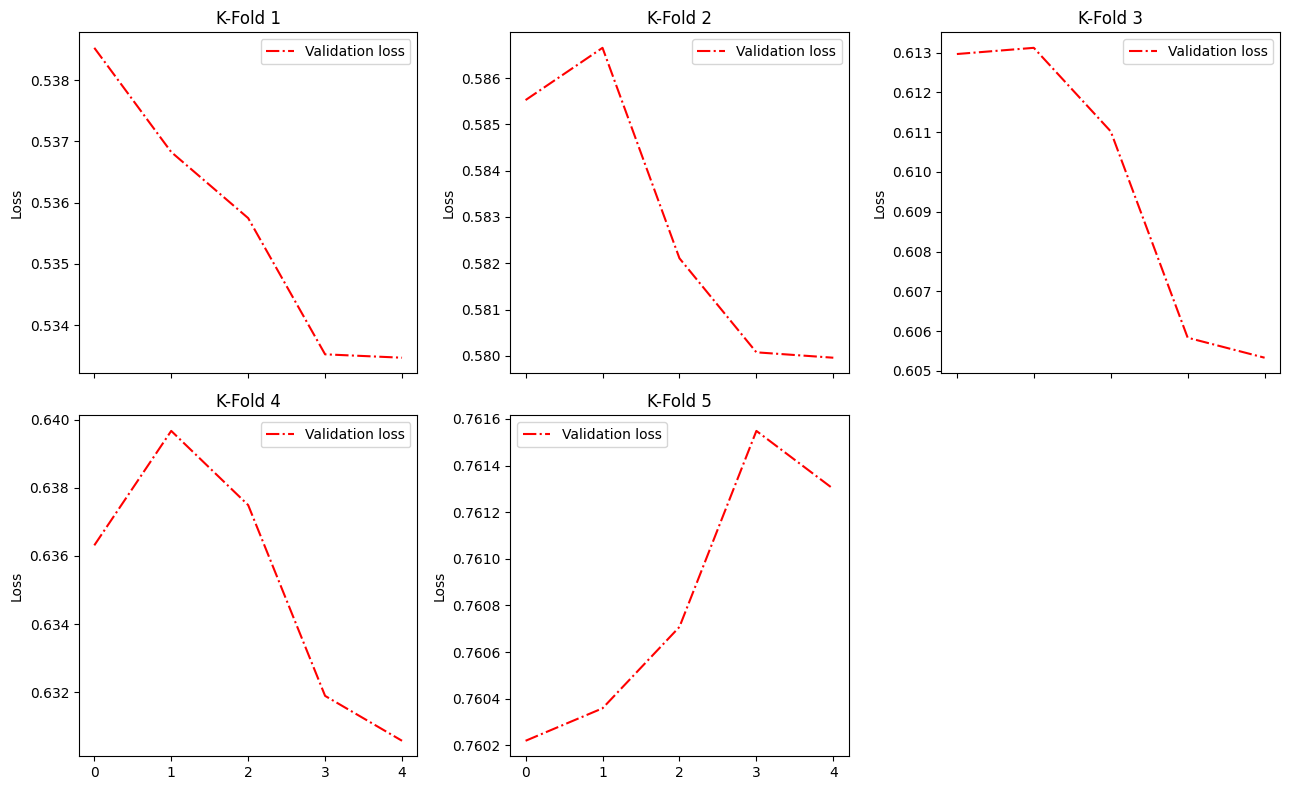

In [ ]:
def plot_losses(epochs, train_loss, val_loss):
    plots = len(train_loss)  # Number of distinct plots
    rows, cols = 2, 3  # Define grid dimensions (2 rows, 3 columns)

    fig, axes = plt.subplots(figsize=(13, 8), nrows=rows, ncols=cols, sharex=True)
    axes = axes.flatten()  # Flatten the axes array for easier indexing
    for i in range(plots):
        # axes[i].plot(range(epochs), train_loss[i], label="Training loss", c="b")
        axes[i].plot(range(epochs), val_loss[i], linestyle="-.", label="Validation loss", c="r")
        axes[i].set_ylabel("Loss")
        axes[i].set_title(f"K-Fold {i+1}")
        axes[i].legend(loc="best")
    for i in range(plots, len(axes)):
        axes[i].axis('off')

    fig.tight_layout()
    plt.show()

# Example usage
plot_losses(epochs=num_epochs, train_loss=historys["loss"], val_loss=historys["val_loss"])

In [ ]:
evaluate_model(test, len(test), cfg["device"], choices=np.random.choice(64, 3).tolist())

Sample predictions range: (max:0.004927477799355984, min:0.004917011596262455) - Targets range: (max:3.601442337036133, min:-1.8865545988082886)


0.7612997194521554

In [ ]:
for i, (inp, target) in enumerate(test):
    with torch.no_grad():
      inp, target = inp.to(cfg["device"]), target.to(cfg["device"])
      preds = model(inp)
    print(f"Predictions: (max:{preds.max().item():.5f}, min:{preds.min().item():.5f}), Targets: (max:{target.max().item():.5f}, min:{target.min().item():.5f})")
    if i == 50:
        break

Predictions: (max:0.00494, min:0.00492), Targets: (max:1.02938, min:-3.28660)
Predictions: (max:0.00494, min:0.00492), Targets: (max:4.49993, min:-1.51084)
Predictions: (max:0.00492, min:0.00492), Targets: (max:1.05039, min:-1.93420)
Predictions: (max:0.00493, min:0.00492), Targets: (max:1.44193, min:-1.66083)
Predictions: (max:0.00493, min:0.00492), Targets: (max:1.24467, min:-1.75284)
Predictions: (max:0.00493, min:0.00492), Targets: (max:1.75757, min:-0.41993)
Predictions: (max:0.00493, min:0.00492), Targets: (max:1.79568, min:-1.84550)
Predictions: (max:0.00494, min:0.00492), Targets: (max:2.32729, min:-3.00819)
Predictions: (max:0.00494, min:0.00492), Targets: (max:2.82608, min:-1.55942)
Predictions: (max:0.00493, min:0.00492), Targets: (max:2.63445, min:-3.56409)
Predictions: (max:0.00499, min:0.00492), Targets: (max:5.00000, min:-3.31374)
Predictions: (max:0.00493, min:0.00492), Targets: (max:2.16331, min:-1.07440)
Predictions: (max:0.00493, min:0.00491), Targets: (max:0.60004, 

In [ ]:
torch.manual_seed(11) #11 #32
model = JaneStreetModelV1(MODEL_CONFIG)
model.apply(init_weights)
torch.save(
    {
        "model_state_dict": model.state_dict(),
    },
    "/content/content/MyDrive/Kaggle Competitions/Jane Street/model_initial_weights.pth"
)

## Multiple Models

In [ ]:
torch.manual_seed(11)
checkpoint = torch.load("/content/content/MyDrive/Kaggle Competitions/Jane Street/model_initial_weights.pth", weights_only=True, map_location=cfg["device"])
cfg["frac"] = None
# models = {}
models = torch.load("/content/content/MyDrive/Kaggle Competitions/Jane Street/models.pth", weights_only=True,map_location=cfg["device"])

for symbol in tqdm(range(len(models.keys()),39), desc="Model training"):
    data_loader = create_dataloader_v1(get_paths([symbol]), cfg)
    model = JaneStreetModelV1(MODEL_CONFIG)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(cfg["device"])
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=5e-3, weight_decay=1e-4
    )
    num_epochs = 5
    history = train_model(epochs=num_epochs, train_loader=data_loader, frac=1, min_lr=3e-4,
                          freq=len(data_loader)//2, device=cfg["device"])
    models[symbol] = model.state_dict()
    print(f"""Epochs: {num_epochs} - Train error: {history["loss"][-1]:.7f}""")
    print()
    torch.save(models, "/content/content/MyDrive/Kaggle Competitions/Jane Street/models.pth")

Processing financial instruments: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


Epoch 1/5
Batch 3679/7360 - 0.026s/step - loss: 0.3211952166218037 - lr: 0.004885044799523537
Batch 7359/7360 - 0.025s/step - loss: 0.3250752079925682 - lr: 0.004551307850160225
train loss: 0.323135212307186
Epoch 2/5
Batch 3679/7360 - 0.026s/step - loss: 0.309794733740526 - lr: 0.004031457641232487
Batch 7359/7360 - 0.026s/step - loss: 0.3233067619825622 - lr: 0.0033763807331995527
train loss: 0.31655074786154414
Epoch 3/5
Batch 3679/7360 - 0.025s/step - loss: 0.3095426500381386 - lr: 0.002650200618008885
Batch 7359/7360 - 0.025s/step - loss: 0.32167700195897614 - lr: 0.0019240008649297207
train loss: 0.31560982599855736
Epoch 4/5
Batch 3679/7360 - 0.026s/step - loss: 0.30865454516340673 - lr: 0.0012688669655246444
Batch 7359/7360 - 0.026s/step - loss: 0.32021788813188956 - lr: 0.0007489279904537092
train loss: 0.31443621664764815
Epoch 5/5
Batch 3679/7360 - 0.027s/step - loss: 0.30833004359598776 - lr: 0.0004150791892247097


Model training:   7%|▋         | 1/15 [17:54<4:10:46, 1074.78s/it]

Batch 7359/7360 - 0.027s/step - loss: 0.3197382674748635 - lr: 0.00030000000856331594
train loss: 0.31403415553542563
Epochs: 5 - Train error: 0.3140342




Processing financial instruments: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

Epoch 1/5


Batch 5865/11732 - 0.025s/step - loss: 0.33744037485301387 - lr: 0.00488502170188806
Batch 11731/11732 - 0.025s/step - loss: 0.3186313017911128 - lr: 0.00455126391065363
train loss: 0.32803583832206334
Epoch 2/5
Batch 5865/11732 - 0.027s/step - loss: 0.32414459381198546 - lr: 0.004031397160959823
Batch 11731/11732 - 0.029s/step - loss: 0.3173255004437099 - lr: 0.0033763096323912987
train loss: 0.32073504712784767
Epoch 3/5
Batch 5865/11732 - 0.029s/step - loss: 0.324072435412742 - lr: 0.002650125856507542
Batch 11731/11732 - 0.027s/step - loss: 0.31706304794943935 - lr: 0.0019239297609119337
train loss: 0.3205677416810907
Epoch 4/5
Batch 5865/11732 - 0.027s/step - loss: 0.32390275918343575 - lr: 0.0012688064791470865
Batch 11731/11732 - 0.027s/step - loss: 0.3168375618638172 - lr: 0.0007488840425444474
train loss: 0.32037016052362643
Epoch 5/5
Batch 5865/11732 - 0.028s/step - loss: 0.3237293071147344 - lr: 0.00041505608171130696


Model training:  13%|█▎        | 2/15 [47:49<5:24:39, 1498.40s/it]

Batch 11731/11732 - 0.029s/step - loss: 0.3166096886055353 - lr: 0.0003000000033701831
train loss: 0.3201694978601348
Epochs: 5 - Train error: 0.3201695




Processing financial instruments: 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

Epoch 1/5


Batch 5975/11952 - 0.026s/step - loss: 0.38646388431371115 - lr: 0.004885020986125125
Batch 11951/11952 - 0.025s/step - loss: 0.37123582886438133 - lr: 0.0045512625490686945
train loss: 0.37884985658904624
Epoch 2/5
Batch 5975/11952 - 0.025s/step - loss: 0.3743521134526711 - lr: 0.004031395286834308
Batch 11951/11952 - 0.026s/step - loss: 0.371957745720739 - lr: 0.003376307429177668
train loss: 0.37315492958670504
Epoch 3/5
Batch 5975/11952 - 0.025s/step - loss: 0.3728827910516564 - lr: 0.002650123539871696
Batch 11951/11952 - 0.026s/step - loss: 0.3705008159742386 - lr: 0.0019239275576223287
train loss: 0.3716918035129475
Epoch 4/5
Batch 5975/11952 - 0.027s/step - loss: 0.37013301925640646 - lr: 0.0012688046048770622
Batch 11951/11952 - 0.028s/step - loss: 0.36924280726177544 - lr: 0.0007488826807606115
train loss: 0.36968791325909095
Epoch 5/5
Batch 5975/11952 - 0.028s/step - loss: 0.36885110865102566 - lr: 0.00041505536571454914
Batch 11951/11952 - 0.028s/step - loss: 0.368500910509

Processing financial instruments: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]

Epoch 1/5


Batch 4486/8974 - 0.025s/step - loss: 0.2891658071566772 - lr: 0.004885033652321141
Batch 8973/8974 - 0.025s/step - loss: 0.2792159377185058 - lr: 0.004551286644117994
train loss: 0.2841908724375915
Epoch 2/5
Batch 4486/8974 - 0.025s/step - loss: 0.2810426351285521 - lr: 0.004031428452145586
Batch 8973/8974 - 0.026s/step - loss: 0.2777685651500965 - lr: 0.00337634641829918
train loss: 0.2794056001393243
Epoch 3/5
Batch 4486/8974 - 0.025s/step - loss: 0.28042529790990384 - lr: 0.0026501645362765752
Batch 8973/8974 - 0.026s/step - loss: 0.2776352587900205 - lr: 0.0019239665482968273
train loss: 0.2790302783499622
Epoch 4/5
Batch 4486/8974 - 0.026s/step - loss: 0.27878902939150113 - lr: 0.0012688377731422948
Batch 8973/8974 - 0.026s/step - loss: 0.2771359436865813 - lr: 0.0007489067798756815
train loss: 0.2779624865390412
Epoch 5/5
Batch 4486/8974 - 0.026s/step - loss: 0.2782927951281498 - lr: 0.00041506803669016533
Batch 8973/8974 - 0.027s/step - loss: 0.2767758652670502 - lr: 0.00030000

Processing financial instruments: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]

Epoch 1/5


Batch 4879/9760 - 0.025s/step - loss: 0.2670845197815234 - lr: 0.004885029558518217
Batch 9759/9760 - 0.025s/step - loss: 0.3131737687302463 - lr: 0.004551278856351713
train loss: 0.2901291442558849
Epoch 2/5
Batch 4879/9760 - 0.025s/step - loss: 0.2565120050694114 - lr: 0.004031417732736772
Batch 9759/9760 - 0.025s/step - loss: 0.31271246192823204 - lr: 0.0033763338165382533
train loss: 0.2846122334988217
Epoch 3/5
Batch 4879/9760 - 0.026s/step - loss: 0.2561252332103561 - lr: 0.0026501512857116973
Batch 9759/9760 - 0.027s/step - loss: 0.3121813972910473 - lr: 0.001923953945985611
train loss: 0.2841533152507017
Epoch 4/5
Batch 4879/9760 - 0.027s/step - loss: 0.2553199873886025 - lr: 0.0012688270526867674
Batch 9759/9760 - 0.027s/step - loss: 0.311657408806524 - lr: 0.0007488989906687236
train loss: 0.2834886980975633
Epoch 5/5
Batch 4879/9760 - 0.028s/step - loss: 0.2548484349894322 - lr: 0.0004150639411936247
Batch 9759/9760 - 0.027s/step - loss: 0.31144098970494194 - lr: 0.000300000

Processing financial instruments: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]

Epoch 1/5


Batch 5873/11749 - 0.025s/step - loss: 0.3499338032712175 - lr: 0.004885041059391514
Batch 11747/11749 - 0.025s/step - loss: 0.32388631066957163 - lr: 0.004551337665026222
train loss: 0.33691005697039456
Epoch 2/5
Batch 5873/11749 - 0.025s/step - loss: 0.34086420423654695 - lr: 0.00403144784753318
Batch 11747/11749 - 0.027s/step - loss: 0.32217559942100127 - lr: 0.0033764289795445396
train loss: 0.3315199018287741
Epoch 3/5
Batch 5873/11749 - 0.030s/step - loss: 0.3408026418538151 - lr: 0.0026501885116025545
Batch 11747/11749 - 0.029s/step - loss: 0.32201960358206166 - lr: 0.0019240491142897447
train loss: 0.3314111227179384
Epoch 4/5
Batch 5873/11749 - 0.028s/step - loss: 0.340652322275266 - lr: 0.0012688571706470258
Batch 11747/11749 - 0.028s/step - loss: 0.3217395038006572 - lr: 0.0007489578132131765
train loss: 0.3311959130379616
Epoch 5/5
Batch 5873/11749 - 0.029s/step - loss: 0.34058130999210845 - lr: 0.0004150754471861382
Batch 11747/11749 - 0.028s/step - loss: 0.321168298232088

Processing financial instruments: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]

Epoch 1/5


Batch 7442/14886 - 0.025s/step - loss: 0.309692275693762 - lr: 0.004885013462827235
Batch 14885/14886 - 0.026s/step - loss: 0.302517743077493 - lr: 0.004551248237751825
train loss: 0.3061050093856275
Epoch 2/5
Batch 7442/14886 - 0.027s/step - loss: 0.3033394504918593 - lr: 0.004031375588389866
Batch 14885/14886 - 0.027s/step - loss: 0.30197566051669766 - lr: 0.003376284271826643
train loss: 0.3026575555042785
Epoch 3/5
Batch 7442/14886 - 0.028s/step - loss: 0.3029466313606519 - lr: 0.0026500991904169525
Batch 14885/14886 - 0.031s/step - loss: 0.3017944063836213 - lr: 0.0019239043995581506
train loss: 0.3023705188721366
Epoch 4/5
Batch 7442/14886 - 0.029s/step - loss: 0.30274949300403947 - lr: 0.001268784905076122
Batch 14885/14886 - 0.030s/step - loss: 0.3016806424746632 - lr: 0.000748868367576682
train loss: 0.30221506773935136
Epoch 5/5
Batch 7442/14886 - 0.029s/step - loss: 0.30265108621669234 - lr: 0.0004150478402217997
Batch 14885/14886 - 0.029s/step - loss: 0.3016043052308278 - l

Processing financial instruments: 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]

Epoch 1/5


Batch 3729/7461 - 0.025s/step - loss: 0.30687639766370245 - lr: 0.004885074528190694
Batch 7459/7461 - 0.025s/step - loss: 0.3588788990727838 - lr: 0.004551422557839561
train loss: 0.33287764836824313
Epoch 2/5
Batch 3729/7461 - 0.025s/step - loss: 0.2893029698873583 - lr: 0.004031535491268518
Batch 7459/7461 - 0.025s/step - loss: 0.356079082260153 - lr: 0.003376566358892338
train loss: 0.32269102607375566
Epoch 3/5
Batch 3729/7461 - 0.025s/step - loss: 0.28790672376424814 - lr: 0.0026502968533460517
Batch 7459/7461 - 0.026s/step - loss: 0.3548609179307285 - lr: 0.001924186505930495
train loss: 0.3213838208474883
Epoch 4/5
Batch 3729/7461 - 0.026s/step - loss: 0.2868830561263352 - lr: 0.0012689448275350682
Batch 7459/7461 - 0.026s/step - loss: 0.3540320788010775 - lr: 0.0007490427382098837
train loss: 0.32045756746370635
Epoch 5/5
Batch 3729/7461 - 0.026s/step - loss: 0.2862525086747557 - lr: 0.00041510893726684055
Batch 7459/7461 - 0.027s/step - loss: 0.35373440897067254 - lr: 0.00030

Processing financial instruments: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

Epoch 1/5


Batch 3099/6201 - 0.026s/step - loss: 0.29823954798544067 - lr: 0.004885093159659209
Batch 6199/6201 - 0.025s/step - loss: 0.27700724735495547 - lr: 0.004551469818224732
train loss: 0.28762339767019807
Epoch 2/5
Batch 3099/6201 - 0.025s/step - loss: 0.2871947256983408 - lr: 0.004031584285051895
Batch 6199/6201 - 0.026s/step - loss: 0.27539733114607273 - lr: 0.0033766428427237896
train loss: 0.2812960284222068
Epoch 3/5
Batch 3099/6201 - 0.027s/step - loss: 0.2868192886999778 - lr: 0.0026503571718774805
Batch 6199/6201 - 0.028s/step - loss: 0.27519017490993947 - lr: 0.0019242629989842043
train loss: 0.28100473180495866
Epoch 4/5
Batch 3099/6201 - 0.028s/step - loss: 0.2865353962658123 - lr: 0.0012689936311856935
Batch 6199/6201 - 0.028s/step - loss: 0.2746592846430928 - lr: 0.0007490900227392355
train loss: 0.28059734045445256
Epoch 5/5
Batch 3099/6201 - 0.027s/step - loss: 0.28559001344646656 - lr: 0.0004151275847008995
Batch 6199/6201 - 0.029s/step - loss: 0.2741368178327778 - lr: 0.0

Processing financial instruments: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]

Epoch 1/5


Batch 7853/15709 - 0.025s/step - loss: 0.2690333355694743 - lr: 0.004885026377791813
Batch 15707/15709 - 0.026s/step - loss: 0.23755150126371385 - lr: 0.004551300427032632
train loss: 0.25329241841659406
Epoch 2/5
Batch 7853/15709 - 0.026s/step - loss: 0.2628766501612671 - lr: 0.004031409404269185
Batch 15707/15709 - 0.029s/step - loss: 0.23610236901928464 - lr: 0.003376368721282494
train loss: 0.24948950959027588
Epoch 3/5
Batch 7853/15709 - 0.028s/step - loss: 0.25997465771502243 - lr: 0.0026501409906944714
Batch 15707/15709 - 0.028s/step - loss: 0.23443674657913066 - lr: 0.0019239888523672432
train loss: 0.24720570214707654
Epoch 4/5
Batch 7853/15709 - 0.028s/step - loss: 0.25949130231644535 - lr: 0.0012688187234665674
Batch 15707/15709 - 0.027s/step - loss: 0.2338128712431939 - lr: 0.0007489205656363879
train loss: 0.24665208677981962
Epoch 5/5
Batch 7853/15709 - 0.028s/step - loss: 0.2591115245303276 - lr: 0.0004150607592494674
Batch 15707/15709 - 0.027s/step - loss: 0.23336286536

Processing financial instruments: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]

Epoch 1/5


Batch 7632/15267 - 0.025s/step - loss: 0.31563112300301 - lr: 0.004885027638922277
Batch 15265/15267 - 0.027s/step - loss: 0.2613811307231307 - lr: 0.004551303625691472
train loss: 0.2885061268630703
Epoch 2/5
Batch 7632/15267 - 0.025s/step - loss: 0.3088062164577701 - lr: 0.004031412706424166
Batch 15265/15267 - 0.027s/step - loss: 0.2611553376458122 - lr: 0.0033763738972628905
train loss: 0.28498077705179115
Epoch 3/5
Batch 7632/15267 - 0.026s/step - loss: 0.3084770597950147 - lr: 0.002650145072563004
Batch 15265/15267 - 0.027s/step - loss: 0.26061111867728465 - lr: 0.0019239940286206088
train loss: 0.2845440892361497
Epoch 4/5
Batch 7632/15267 - 0.026s/step - loss: 0.30822211748306777 - lr: 0.0012688220259136093
Batch 15265/15267 - 0.025s/step - loss: 0.26031611555386014 - lr: 0.0007489237650098705
train loss: 0.284269116518464
Epoch 5/5
Batch 7632/15267 - 0.025s/step - loss: 0.3080596490627694 - lr: 0.00041506202085249443
Batch 15265/15267 - 0.026s/step - loss: 0.2600357311635443 -

Processing financial instruments: 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

Epoch 1/5


Batch 4748/9498 - 0.025s/step - loss: 0.298758879346733 - lr: 0.004885030847842491
Batch 9497/9498 - 0.025s/step - loss: 0.26243291066021707 - lr: 0.004551281309064579
train loss: 0.28059589500347504
Epoch 2/5
Batch 4748/9498 - 0.026s/step - loss: 0.287675234128302 - lr: 0.004031421108749606
Batch 9497/9498 - 0.026s/step - loss: 0.2582351785434273 - lr: 0.0033763377853833973
train loss: 0.2729552063358647
Epoch 3/5
Batch 4748/9498 - 0.026s/step - loss: 0.2859480672978354 - lr: 0.0026501554588909365
Batch 9497/9498 - 0.027s/step - loss: 0.2571779398367373 - lr: 0.0019239579149990843
train loss: 0.27156300356728635
Epoch 4/5
Batch 4748/9498 - 0.027s/step - loss: 0.2852205533783249 - lr: 0.0012688304290197825
Batch 9497/9498 - 0.027s/step - loss: 0.2566100305883362 - lr: 0.0007489014438222807
train loss: 0.27091529198333053
Epoch 5/5
Batch 4748/9498 - 0.027s/step - loss: 0.28474157457247773 - lr: 0.00041506523103596103
Batch 9497/9498 - 0.027s/step - loss: 0.25643989831705044 - lr: 0.0003

Processing financial instruments: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

Epoch 1/5


Batch 5935/11872 - 0.025s/step - loss: 0.2867386267421879 - lr: 0.0048850212433334955
Batch 11871/11872 - 0.026s/step - loss: 0.3213488241261693 - lr: 0.004551263038352001
train loss: 0.30404372543417857
Epoch 2/5
Batch 5935/11872 - 0.027s/step - loss: 0.28008235848529645 - lr: 0.004031395960298091
Batch 11871/11872 - 0.028s/step - loss: 0.3206852236732441 - lr: 0.0033763082208985995
train loss: 0.30038379107927027
Epoch 3/5
Batch 5935/11872 - 0.028s/step - loss: 0.27987154164258016 - lr: 0.0026501243723506145
Batch 11871/11872 - 0.029s/step - loss: 0.32042831544624467 - lr: 0.0019239283493703988
train loss: 0.3001499285444124
Epoch 4/5
Batch 5935/11872 - 0.029s/step - loss: 0.279725362377218 - lr: 0.001268805278392465
Batch 11871/11872 - 0.030s/step - loss: 0.3202661556736792 - lr: 0.0007488831701149674
train loss: 0.2999957590254486
Epoch 5/5
Batch 5935/11872 - 0.029s/step - loss: 0.27967441214697725 - lr: 0.00041505562300644494
Batch 11871/11872 - 0.028s/step - loss: 0.3202534122998

Processing financial instruments: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]

Epoch 1/5


Batch 4909/9821 - 0.025s/step - loss: 0.3435574341186013 - lr: 0.004885052492228355
Batch 9819/9821 - 0.025s/step - loss: 0.3352148026093279 - lr: 0.004551366663597948
train loss: 0.3393861183639646
Epoch 2/5
Batch 4909/9821 - 0.025s/step - loss: 0.33092286383511227 - lr: 0.004031477785289601
Batch 9819/9821 - 0.027s/step - loss: 0.33471609859731116 - lr: 0.003376475906014859
train loss: 0.33281948121621174
Epoch 3/5
Batch 4909/9821 - 0.027s/step - loss: 0.33052589399493515 - lr: 0.002650225519073148
Batch 9819/9821 - 0.027s/step - loss: 0.334454612970227 - lr: 0.001924096044341967
train loss: 0.3324902534825811
Epoch 4/5
Batch 4909/9821 - 0.027s/step - loss: 0.3302723383923609 - lr: 0.0012688871122358638
Batch 9819/9821 - 0.027s/step - loss: 0.33428592537529767 - lr: 0.0007489868211624478
train loss: 0.3322791318838293
Epoch 5/5
Batch 4909/9821 - 0.027s/step - loss: 0.3300137373002326 - lr: 0.0004150868862239608
Batch 9819/9821 - 0.027s/step - loss: 0.33404037983369184 - lr: 0.0003000

Processing financial instruments: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

Epoch 1/5


Batch 7697/15397 - 0.025s/step - loss: 0.2586796625043844 - lr: 0.004885027260486038
Batch 15395/15397 - 0.025s/step - loss: 0.2560098191995317 - lr: 0.004551302665846819
train loss: 0.257344740851958
Epoch 2/5
Batch 7697/15397 - 0.027s/step - loss: 0.25207032812992775 - lr: 0.00403141171552201
Batch 15395/15397 - 0.027s/step - loss: 0.25565437708271654 - lr: 0.0033763723440677564
train loss: 0.2538623526063222
Epoch 3/5
Batch 7697/15397 - 0.027s/step - loss: 0.25183049354765263 - lr: 0.002650143847685874
Batch 15395/15397 - 0.027s/step - loss: 0.25552829946926026 - lr: 0.0019239924753427446
train loss: 0.25367939650845645
Epoch 4/5
Batch 7697/15397 - 0.026s/step - loss: 0.2517106723860966 - lr: 0.0012688210349229372
Batch 15395/15397 - 0.027s/step - loss: 0.2554496123232736 - lr: 0.000748922804948627
train loss: 0.2535801423546851
Epoch 5/5
Batch 7697/15397 - 0.026s/step - loss: 0.2516941564078906 - lr: 0.0004150616422730341
Batch 15395/15397 - 0.026s/step - loss: 0.2554492306044806 -

Model training: 100%|██████████| 15/15 [6:57:48<00:00, 1671.21s/it]
